In [30]:
import numpy as np
import pandas as pd 
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

tqdm.pandas()

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small", torch_dtype=torch.float16)
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small", output_hidden_states=True).to(device)

In [32]:
data = pd.read_json('./data/all_datasets_300.json')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
def get_hidden_states(row, pos): 
    
    inputs = tokenizer(row['input_text'], return_tensors='pt').input_ids.to(device)
    # print(tokenizer.tokenize(row['input_text']))
    with torch.no_grad():
        outputs = model.generate(inputs, output_hidden_states=True, return_dict_in_generate=True, num_beams=1, num_return_sequences=1, max_length=100, early_stopping=True, use_cache=True)
    # print(inputs.shape)
    # print(outputs['sequences'].shape)
    hidden = outputs['decoder_hidden_states'][0][pos][0][0].cpu().numpy()
    #print(hidden)
    pred = tokenizer.decode(outputs['sequences'][0], skip_special_tokens=True)
    #print(tokenizer.decode(outputs['sequences'][0], skip_special_tokens=True))

    return pred, hidden

In [34]:
data

,input_text,output_text,label_space,Instruction Type
0,"In this task, you are given a multiple-choice...",A,"[A, B, C, D]",MMLU - Observed
1,"In this task, you are given a multiple-choice...",D,"[A, B, C, D]",MMLU - Observed
2,"In this task, you are given a multiple-choice...",C,"[A, B, C, D]",MMLU - Observed
3,"In this task, you are given a multiple-choice...",B,"[A, B, C, D]",MMLU - Observed
4,"In this task, you are given a multiple-choice...",D,"[A, B, C, D]",MMLU - Observed
...,...,...,...,...
11995,You are now a very experienced judge. Based on...,False,"[True, False, Neither]",BBL - Unobserved
11996,You are now a very experienced judge. Based on...,False,"[True, False, Neither]",BBL - Unobserved
11997,You are now a very experienced judge. Based on...,True,"[True, False, Neither]",BBL - Unobserved
11998,You are now a very experienced judge. Based on...,True,"[True, False, Neither]",BBL - Unobserved


In [35]:
data['output'] = data.progress_apply(lambda row: get_hidden_states(row, 1), axis=1)
data['output_generated'] = data['output'].apply(lambda x: x[0].lstrip(' '))
data['hidden_state'] = data['output'].apply(lambda x: x[1])
data = data.drop(columns=['output'])

100%|██████████| 12000/12000 [05:30<00:00, 36.27it/s]


In [36]:
from pprint import pprint
data

,input_text,output_text,label_space,Instruction Type,output_generated,hidden_state
0,"In this task, you are given a multiple-choice...",A,"[A, B, C, D]",MMLU - Observed,B,"[-8.187847, 1.1971915, -1.5220388, -2.25033, 1..."
1,"In this task, you are given a multiple-choice...",D,"[A, B, C, D]",MMLU - Observed,B,"[-8.735186, 1.1629927, -1.7532597, -2.1903682,..."
2,"In this task, you are given a multiple-choice...",C,"[A, B, C, D]",MMLU - Observed,C,"[-8.151314, 1.251602, -1.5312729, -2.308899, 1..."
3,"In this task, you are given a multiple-choice...",B,"[A, B, C, D]",MMLU - Observed,B,"[-7.7912083, 1.209523, -1.3683867, -2.2609382,..."
4,"In this task, you are given a multiple-choice...",D,"[A, B, C, D]",MMLU - Observed,B,"[-8.52363, 1.0854083, -1.5243589, -2.103545, 1..."
...,...,...,...,...,...,...
11995,You are now a very experienced judge. Based on...,False,"[True, False, Neither]",BBL - Unobserved,True,"[-8.25091, 0.96559954, -1.3667152, -3.0949066,..."
11996,You are now a very experienced judge. Based on...,False,"[True, False, Neither]",BBL - Unobserved,True,"[-8.289024, 0.9768846, -1.3287687, -2.4995108,..."
11997,You are now a very experienced judge. Based on...,True,"[True, False, Neither]",BBL - Unobserved,True,"[-8.691332, 0.86426497, -1.5467311, -2.5264926..."
11998,You are now a very experienced judge. Based on...,True,"[True, False, Neither]",BBL - Unobserved,True,"[-8.5189495, 0.91111374, -1.4780655, -2.427933..."


In [37]:
tasks = {}

for cls in data['Instruction Type'].unique():
    tasks[cls] = list(data.index[data['Instruction Type'] == cls])

# pprint(tasks)

In [38]:
from sklearn.manifold import TSNE
import altair as alt 

In [39]:
def run_tsne(dataset):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(2, verbose=1)
    tsne_proj = tsne.fit_transform(np.array(dataset['hidden_state'].tolist()))
    dtsne = pd.DataFrame(tsne_proj, columns=["x1", "x2"])

    dtsne['label'] = dataset['output_generated'].tolist()
    dtsne['answer'] = dataset['output_text'].tolist()
    dtsne['class'] = dataset['Instruction Type'].tolist()

    return dtsne

In [40]:
def plot_tsne(dataset):
    chart = alt.Chart(dataset).mark_circle().encode(
        x='x1',
        y='x2',
        color=alt.Color('class:O'),
        size=alt.value(50),
    ).properties(title = "t-SNE", width = 600, height = 600).configure_title(
        fontWeight= 'normal',
        fontSize = 20,
    ).configure_axisX(
        grid=False, 
        domain=True,
    ).configure_axisY(
        grid=False, 
        domain=True,
    ).configure_axis(
        labelFontWeight='normal',
        titleFontWeight='normal',
        labelFontSize=13,
        titleFontSize=16
    ).configure_legend(
        orient = 'right'
    ).configure_view(
        strokeWidth=0
    ).configure_range(
        category={'scheme': 'green'}
    ).configure_scale(
        bandPaddingInner=0.3
    )

    return chart

In [41]:
dtsne=run_tsne(data)
# plot_tsne(dtsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.002s...
[t-SNE] Computed neighbors for 12000 samples in 4.591s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 1.062510
[t-SNE] KL divergence

In [42]:
dtsne["correct?"] = (dtsne["label"] == dtsne["answer"])

6000

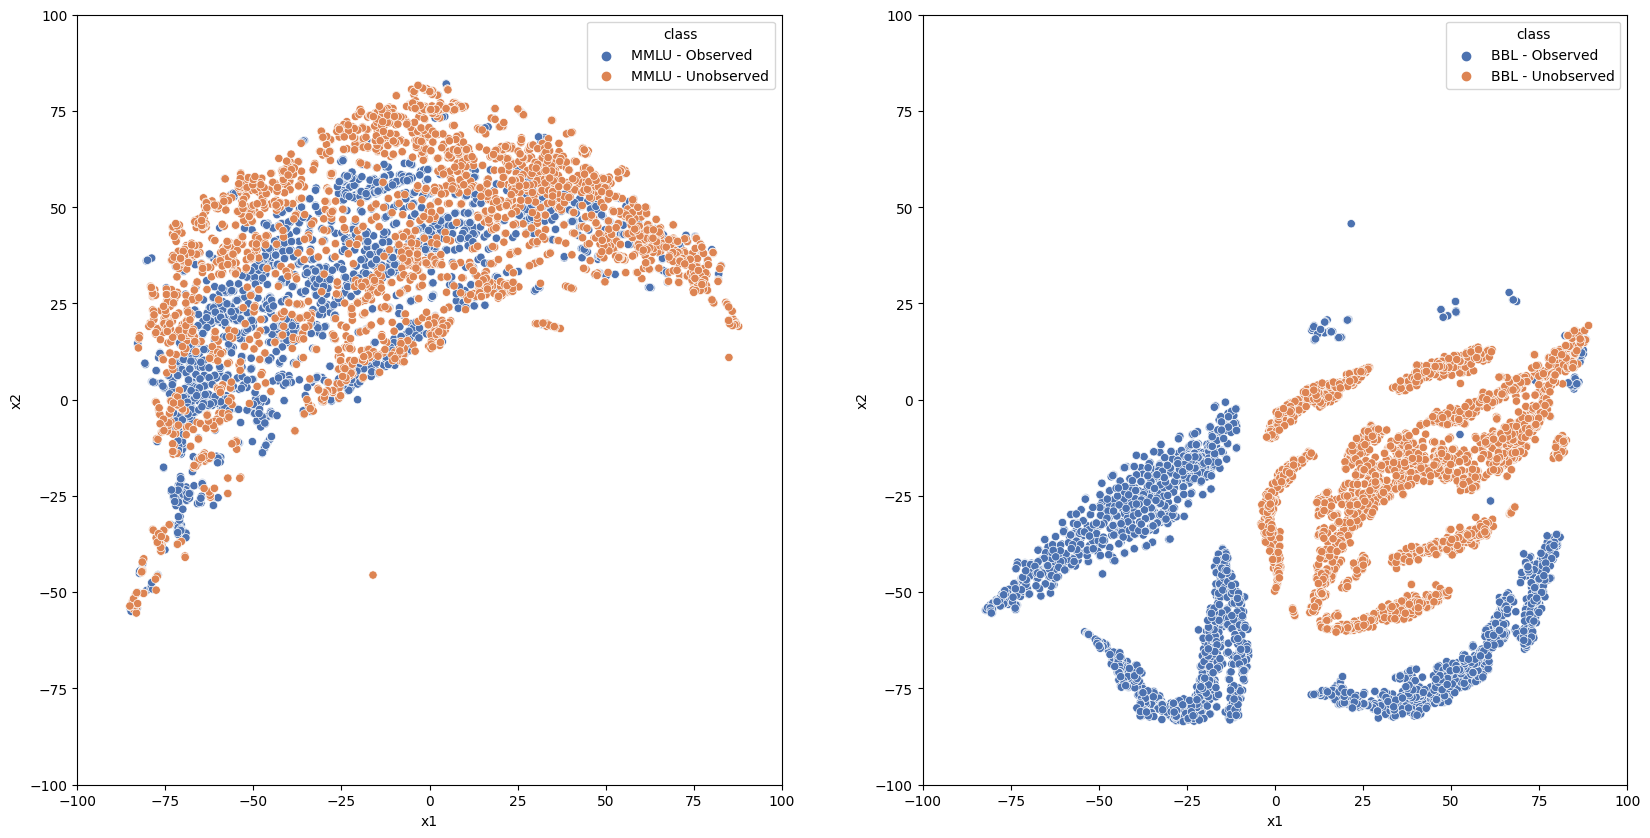

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

mmlu_df = dtsne[(dtsne['class'] == 'MMLU - Observed') | (dtsne['class'] == 'MMLU - Unobserved')]
bbl_df = dtsne[(dtsne['class'] == 'BBL - Observed') | (dtsne['class'] == 'BBL - Unobserved')]
sns.scatterplot(ax=axes[0], data=mmlu_df, x="x1", y="x2", hue="class", palette="deep")
sns.scatterplot(ax=axes[1], data=bbl_df, x="x1", y="x2", hue="class", palette="deep")
axes[0].set_xlim(-100, 100)
axes[0].set_ylim(-100, 100)
axes[1].set_xlim(-100, 100)
axes[1].set_ylim(-100, 100)
len(mmlu_df)

In [44]:
import json
data.to_json("./data/data_300_small.json")